# ADAML workshop 3: Recurrent Neural Network



___

## Model implementation

(1200, 20, 1) (1200, 1)

Test MSE: 0.044319



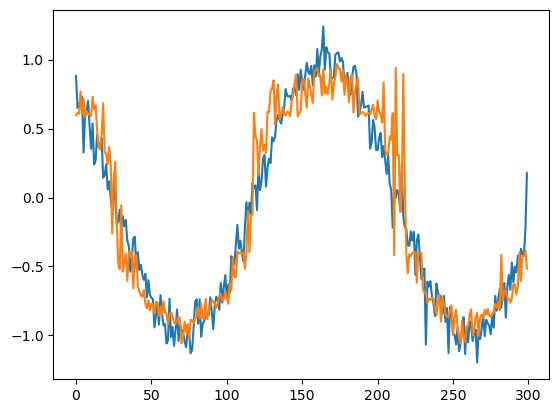

In [46]:
import numpy as np
import matplotlib.pyplot as plt

class RNN:
    def __init__(self, input_size, hidden_size, output_size, lr=1e-3, seed=1):
        rng = np.random.RandomState(seed)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.lr = lr
        self.Wxh = rng.randn(hidden_size, input_size)
        self.Whh = rng.randn(hidden_size, hidden_size)
        self.Why = rng.randn(output_size, hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    # In forward model we feed the data X through the network
    def forward(self, X: np.ndarray): 
        #assert X.ndim == 3, "X must be a 3D matrix"
        
        # Determine batch size and sequence length
        batch, seq_len, _ = X.shape

        # Initialize hidden state
        h = np.zeros((batch, seq_len+1, self.hidden_size))

        # Propagate the input trough hidden layers
        for t in range(seq_len): 

            # Reshape the input
            xt = X[:, t, :].reshape(batch, 1)

            # Compute the hidden layer output.T
            pre = xt.dot(self.Wxh.T) + h[:, t, :].dot(self.Whh.T) + self.bh.T
            h[:, t+1, :] = np.tanh(pre) # Apply activation function to hidden state (here, tanh is used)

            # Compute the output 
            y_pred = h[:, -1, :].dot(self.Why.T) + self.by

        # Return hidden state and predicted output
        return h, y_pred

    # Compute the Mean Square Error loss
    def loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        diff = y_true - y_pred
        return np.mean(diff**2), diff

    # Backpropagation
    def bptt_update(self, X, h, y_pred, y_true):
        # Using backpropagation through time (bptt) to update the weights
        # X: (batch, seq_len, input_size)

        batch_size, seq_len, _ = X.shape

        # Init the gradients
        dWxh, dWhh, dWhy= np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)

        # Compute the gradient of the output wrt. loss
        dy = (y_pred - y_true) * (2.0 / batch_size)

        h_lash = h[:, -1, :].reshape(batch_size, self.hidden_size)

        # Compute the gradients of the loss wrt. output layer weights and biases
        dWhy += dy.T.dot(h_lash)
        dby += dy.T.sum(axis=1, keepdims=True)

        # Compute the gradient of the loss wrt the hidden state
        dh_next = dy.dot(self.Why)

        for t in reversed(range(seq_len)): 
            ht = h[:, t+1, :]
            ht_prev = h[:, t, : ]

            # Gradient of the activation function (tanh) and hidden biases
            dt = dh_next*(1 - ht**2)
            dbh = dt.T.sum(axis=1, keepdims=True)

            # Get inputs at t
            xt = X[:, t, :].reshape(batch_size, -1)

            # Comute the gradients of the hidden weights and hidden state
            dWxh += dt.T.dot(xt)
            dWhh += dt.T.dot(ht_prev)

            # Compute the gradient that is propagated to the next time step 
            dh_next = dt.dot(self.Whh)

        # Clip the gradients for numerical stability
        for grad in (dWhh, dWxh, dWhy, dbh, dby): 
            np.clip(grad, -5, 5, out=grad)

        # Update the parameters
        self.Wxh -= self.lr * dWxh
        self.Whh -= self.lr * dWhh
        self.Why -= self.lr * dWhy
        self.bh -= self.lr * dbh
        self.by -= self.lr * dby
        return 

    def train(self, X, y, epochs=50, batch_size=32, verbose=True):
        #assert X.ndim == 3 and len(y) == y.size, 'X must be a 3D matrix and y must be a vector'
        assert len(X) == len(y), 'X and y must be the same length'
        
        # Length of X
        n = X.shape[0]
        losses=[]

        # Training loop
        for epoch in range(1, epochs + 1): 

            # Shuffle the indices
            idx = np.random.permutation(n)
            X_shuffled, y_shuffled = X[idx], y[idx]

            # Iterate over batches
            loss_epoch = 0.0
            for i in range(0, n, batch_size): 

                # Take one batch
                X_batch, y_batch = X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]

                # Forward propagate the batch
                h, y_pred = self.forward(X_batch)

                # Compute model loss
                loss, _ = self.loss(y_pred, y_batch)
                loss_epoch += loss * X_batch.shape[0]

                # Compute the gradient wrt. loss and backward propagate
                self.bptt_update(X_batch, h, y_pred, y_batch)

            # Normalize the loss
            loss_epoch /= n
            losses.append(loss_epoch)

        # Return the loss history
        return losses

def generate_sine_sequences(n_samples=2000, seq_len=20, input_size=1, seed=0):
    rng = np.random.RandomState(seed)
    x = np.linspace(0, 50, n_samples * seq_len * input_size)
    data = np.sin(x) + 0.1 * rng.randn(n_samples * seq_len * input_size)
    X = data.reshape(n_samples, seq_len, input_size)
    rolled = np.roll(data, -1).reshape(n_samples, seq_len, input_size)
    y_last = rolled[:, -1, :]
    return X.astype(np.float32), y_last.astype(np.float32)

if True: 
    # Creating the data
    X, y = generate_sine_sequences(n_samples=1500, seq_len=20, input_size=1)
    # train/test split
    split = int(0.8 * X.shape[0])
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    print(X_train.shape, y_train.shape)

    # Training the network
    rnn = RNN(input_size=1, hidden_size=80, output_size=1, lr=1e-3)
    losses = rnn.train(X_train, y_train, epochs=600, batch_size=8, verbose=True)

    # Test set
    _, y_pred_test = rnn.forward(X_test)
    test_loss, _ = rnn.loss(y_pred_test, y_test)
    print(f"\nTest MSE: {test_loss:.6f}\n")

    # Plotting the predictions.
    plt.plot(y_test)
    plt.plot(y_pred_test)
    plt.savefig("rnn_pred.png")
    plt.show()

___

## Classification model implementation



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class ClassificationRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(ClassificationRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

___

## Data onboarding

Fetch the data from kaggle API

In [52]:
import os
import pandas as pd
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("tanishqdublish/text-classification-documentation")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

data = pd.read_csv(data_path)
print(data.shape)
print(data.head())

(2225, 2)
                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0


Split the data to features and labels

In [48]:
X, y = data['Text'], data['Label']

___

## Data preprocessing

In [49]:
import re 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Stop-word removal
    # words = [word for word in words if word not in stopwords]

    return ' '.join(words)

# Apply the cleaning function
X = X.apply(clean_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eliaseskelinen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
import nltk
import re
nltk.download('punkt')

# Tokenize each sentence
for i, x in enumerate(X): 
    #tokens = nltk.word_tokenize(x)
    tokens = nltk.word_tokenize(x)
    X[i] = tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliaseskelinen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
X, y = X.to_numpy(), y.to_numpy()
print(X.shape)

(2225,)


Split the data to training and test sets

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

___

## Model training

In [ ]:
model = RNN(1, )

In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv", names=["text", "label"])

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

vocab = {word for phrase in df['text'] for word in phrase}
word_to_idx = {word: idx for idx, word in enumerate(vocab, start=1)}

max_length = df['text'].str.len().max()

def encode_and_pad(text):
    encoded = [word_to_idx[word] for word in text]
    return encoded + [0] * (max_length - len(encoded))

train_data['text'] = train_data['text'].apply(encode_and_pad)
test_data['text'] = test_data['text'].apply(encode_and_pad)
vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2 
model = ClassificationRNN(vocab_size, embed_size, hidden_size, output_size)

ValueError: not enough values to unpack (expected 3, got 1)

___